# Image Captioning using a ResNet-50 Encoder and a Transformer - Based Decoder

## 1. Importing all the necessary libraries and Declaring the constant variables

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from collections import Counter, defaultdict

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import math
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import os

import random
import textwrap

In [ ]:
# Declaring constants
EMBED_SIZE = 512
BATCH_SIZE = 64
NUM_HEADS = 4
NUM_LAYERS = 4
MAX_LEN = 50
VOCAB_THRESHOLD = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Declaring paths
IMAGE_DIR = os.path.join(os.getcwd(), 'Flickr8k_Dataset/Flicker8k_Dataset/')
CAPTIONS_FILE = os.path.join(os.getcwd(), 'Flickr8k_text/Flickr8k.token.txt')
TRAIN_CAPTIONS_FILE = os.path.join(os.getcwd(), 'Flickr8k_text/Flickr_8k.trainImages.txt')
VAL_CAPTIONS_FILE = os.path.join(os.getcwd(), 'Flickr8k_text/Flickr_8k.devImages.txt')
TEST_CAPTIONS_FILE = os.path.join(os.getcwd(), 'Flickr8k_text/Flickr_8k.testImages.txt')

In [ ]:
# Download the NLTK punkt tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sidsu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

___
## 2. Data Preprocessing

In [ ]:
# Creating a custom class for the Vocabulary - This class will handle the tokenization and encoding of the captions
class Vocabulary:
    # Initializing the Vocabulary class with a minimum threshold for word frequency
    def __init__(self, min_threshold):
        self.min_threshold = min_threshold
        self.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.stoi = {val: key for key, val in self.itos.items()}
    
    # Defining the length of the vocabulary
    def __len__(self):
        return len(self.itos)
    
    # Tokenizing the text using NLTK
    @staticmethod
    def tokenizer(text):
        return nltk.tokenize.word_tokenize(text.lower())
    
    # Building the vocabulary from the sentences
    def build_vocab(self, sentences):
        freq = Counter()
        idx = 4
        for sentence in sentences:
            for word in self.tokenizer(sentence):
                if word not in freq:
                    freq[word] = 1
                else:
                    freq[word] += 1
                
                if freq[word] == self.min_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    # Encoding the text into token IDs
    def encode(self, text):
        return [self.stoi.get(word, self.stoi['<UNK>']) for word in self.tokenizer(text)]
    
    # Decoding the token IDs back into text
    def decode(self, token_ids, skip_special_tokens=True):
        tokens = []
        for idx in token_ids:
            word = self.itos.get(idx, '<UNK>')
            if skip_special_tokens and word in ['<PAD>', '<SOS>', '<EOS>']:
                continue
            tokens.append(word)
        return ' '.join(tokens)

In [ ]:
#  Creating a custom class for the Flickr dataset - This class will handle the loading and processing of the images and captions
class FlickrDataset(Dataset):
    # Initializing the dataset with the image directory, captions file, and a list of images
    def __init__(self, image_dir, captions_dir, image_list_file, transforms = None, min_threshold = 3):
        
        self.image_dir = image_dir
        self.transform = transforms

        with open(image_list_file, 'r') as f:
            image_list = set(line.strip() for line in f)
        
        self.samples = []

        with open(captions_dir, 'r') as f:
            for line in f:
                img_cap, caption = line.strip().split('\t')
                img_name, _ = img_cap.split('#')

                if img_name in image_list:
                    self.samples.append((img_name, caption))
        
        self.img = [img for img, _ in self.samples]
        self.captions = [cap for _, cap in self.samples]

        self.vocab = Vocabulary(min_threshold)
        self.vocab.build_vocab(self.captions)
    
    # Defining the length of the dataset
    def __len__(self):
        return len(self.samples)

    # Getting the item at a specific index
    def __getitem__(self, index):
        img_id = self.img[index]
        caption = self.captions[index]
        img = Image.open(os.path.join(self.image_dir, img_id)).convert('RGB')

        if self.transform:
            img = self.transform(img)
        
        numericalized = [self.vocab.stoi['<SOS>']] + self.vocab.encode(caption) + [self.vocab.stoi['<EOS>']]
        return  img, torch.tensor(numericalized)

In [ ]:
#  Creating a custom class for the Collate function - This class will handle the padding of sequences in a batch
class Collate:
    # Initializing the Collate class with a padding index and batch_first flag
    def __init__(self, pad_index, batch_first = True):
        self.pad_index = pad_index
        self.batch_first = batch_first

    # Defining the call method to handle the padding of sequences
    def __call__(self, batch):
        imgs = torch.stack([item[0] for item in batch], dim = 0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first = self.batch_first, padding_value = self.pad_index)
        return imgs, targets

In [23]:
# Transforming the images within the dataset
transform = transforms.Compose([
    # Resize the images to 224 x 224 which is used for models trained on ImageNet
    transforms.Resize((224, 224)),
    # Convert the images to tensors
    transforms.ToTensor(),
    # Normalize the pixel values to be between 0 and 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Importing the training dataset
train_dataset = FlickrDataset(
    image_dir = IMAGE_DIR, 
    captions_dir = CAPTIONS_FILE,
    image_list_file = TRAIN_CAPTIONS_FILE,
    transforms = transform,
    min_threshold = VOCAB_THRESHOLD
)

# Importing the vaidation dataset
val_dataset = FlickrDataset(
    image_dir = IMAGE_DIR, 
    captions_dir = CAPTIONS_FILE,
    image_list_file = VAL_CAPTIONS_FILE,
    transforms = transform,
    min_threshold = VOCAB_THRESHOLD
)

# Importing the test dataset
test_dataset = FlickrDataset(
    image_dir = IMAGE_DIR, 
    captions_dir = CAPTIONS_FILE,
    image_list_file = TEST_CAPTIONS_FILE,
    transforms = transform,
    min_threshold = VOCAB_THRESHOLD
)

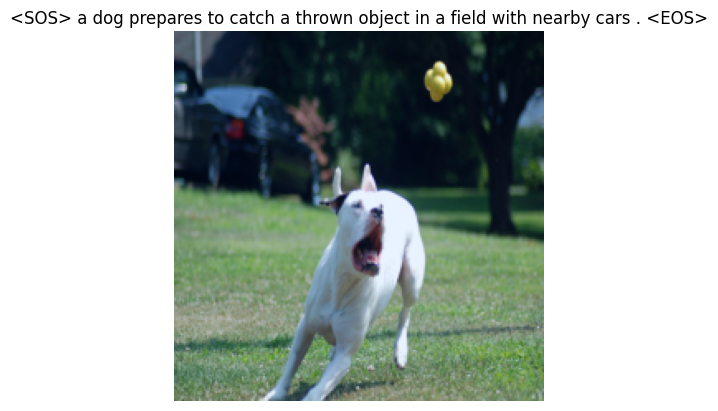

In [ ]:
# Display an image and its caption

# Choose a random index from the training dataset
index = 70

# Get image and caption
img, caption_tensor = train_dataset[index]
image_np = img.permute(1, 2, 0).numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Decode the caption tensor back to text
caption_tokens = caption_tensor.tolist()
caption_words = [train_dataset.vocab.itos[token] for token in caption_tokens]
caption = ' '.join(caption_words)

# Display image and caption
plt.imshow(image_np)
plt.axis('off')
plt.title(caption)
plt.show()

In [ ]:
# Instantiating the Collate class
collate_fn = Collate(pad_index=0, batch_first=True)

In [ ]:
# Creating the DataLoader for the training dataset
train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    collate_fn = collate_fn
)

# Creating the DataLoader for the validation dataset
val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    collate_fn = collate_fn
)

# Creating the DataLoader for the test dataset
test_loader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    collate_fn = collate_fn
)

In [ ]:
# Ensuring that the vocabulary is the same across all datasets
val_dataset.vocab = train_dataset.vocab
test_dataset.vocab = train_dataset.vocab

___
## 3. Encoder Model: Pre-trained ResNet-50 CNN with frozen parameters

In [ ]:
# Creating a custom class for the Encoder CNN - This class will handle the encoding of the images using a pre-trained CNN model (ResNet50)
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, use_spatial_features = False, train_cnn = False):
        super(EncoderCNN, self).__init__()
        self.train_cnn = train_cnn
        # The CNN model will provide spatial features, which are required for Transformer, if True
        # The CNN model will provide global features, which are required for LSTM, if False
        self.use_spatial_features = use_spatial_features

        # Load the pre-trained ResNet50 model
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2 if use_spatial_features else -1]
        self.resnet = nn.Sequential(*modules)
        
        # Freeze the parameters of the CNN model
        for param in self.resnet.parameters():
            param.requires_grad = self.train_cnn
        
        # The final fully connected layer will be used to project the features to the desired embedding size
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
    
    # Forward pass through the CNN model to extract features from the images
    def forward(self, images):
        features = self.resnet(images)

        if self.use_spatial_features:
            features = features.flatten(2).permute(0, 2, 1)
            features = self.fc(features)
        else:
            features = features.view(features.size(0), -1)
            features = self.fc(features)

        return features

In [ ]:
# Instatiate the EncoderCNN class
encoder = EncoderCNN(embed_size = EMBED_SIZE, use_spatial_features = True).to(DEVICE)

___
## 4. Decoder Model: Transformer - Based Decoder

In [ ]:
# Creating a custom class for the Positional Encoding - This class will handle the positional encoding for the input embeddings within the Transformer
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(SinusoidalPositionalEncoding, self).__init__()
        # The positional encoding is initialized with zeros
        pe = torch.zeros(max_len, embed_dim)
        # The position is a tensor of shape (max_len, 1)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)

        # The positional encoding is calculated using sine and cosine functions
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # (1, max_len, embed_dim)
        self.register_buffer('pe', pe)

    # Forward pass through the positional encoding layer where the positional encoding is added to the input embeddings
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
# Creating a custom class for the Residual Block - This class will handle the residual connections within the Transformer
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim):
        super(ResidualBlock, self).__init__()
        
        # The residual block consists of two linear layers with ReLU activation in between
        self.layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
    
    # Forward pass through the residual block where the input is added to the output of the layer
    def forward(self, x):
        return x + self.layer(x)

In [ ]:
# Creating a custom class for the Decoder Transformer - This class will handle the decoding of the image features into captions using a Transformer model
# The Transformer model consists of multiple layers of self-attention and feed-forward networks which are used to process the input sequence 
# and generate the output sequence

class DecoderTransformer(nn.Module):
    def __init__(self, feature_size=512, hidden_size=512, vocab_size=2002, num_layers=4, num_heads=4, max_len=50):
        super(DecoderTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoder = SinusoidalPositionalEncoding(hidden_size, max_len=max_len)
        self.res_block = ResidualBlock(hidden_size)

        # The TransformerDecoderLayer is a single layer of the Transformer decoder which consists of 4 heads
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads)
        # The TransformerDecoder is the full decoder which consists of multiple layers of the Transformer decoder
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        # Clamp caption token values within vocab range
        captions = torch.clamp(captions, min=0, max=2001)

        # Get embedding + sinusoidal position encoding
        embedded = self.embedding(captions)
        embedded = self.pos_encoder(embedded)

        # Generate causal mask for decoder to prevent attending to future tokens
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(embedded.size(1)).to(embedded.device)

        # Reshape features to match the expected input shape for the transformer decoder
        tgt = embedded.permute(1, 0, 2)
        memory = features.permute(1, 0, 2)

        # Decode and project
        output = self.transformer_decoder(tgt, memory, tgt_mask=tgt_mask)  
        output = output.permute(1, 0, 2)           
        return self.fc(output)                     


In [ ]:
# Instantiate the DecoderTransformer class
decoder = DecoderTransformer(
    feature_size = EMBED_SIZE,           # Must match your ResNet output dim
    hidden_size=EMBED_SIZE,
    vocab_size=len(train_dataset.vocab),
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    max_len=MAX_LEN
).to(DEVICE)

___
## 5. Training the model

In [ ]:
# Train the model using the Adam optimizer and CrossEntropyLoss
def train_model(encoder, decoder, train_loader, val_loader, epochs=10, lr=1e-4):
    # Set the model to training mode
    encoder.train()
    decoder.train()

    pad_idx = 0
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    opt = torch.optim.Adam(decoder.parameters(), lr=lr)

    # Start the training loop
    for epoch in range(epochs):
        total_train_loss = 0

        for imgs, captions in train_loader:
            # Move the images and captions to the device (GPU) 
            imgs, captions = imgs.to(DEVICE), captions.to(DEVICE)

            # Prepare the inputs and targets for the model using Teacher Forcing
            inputs = captions[:, :-1]
            targets = captions[:, 1:]

            # Zero the gradients
            opt.zero_grad()

            # Forward pass through the encoder and decoder
            features = encoder(imgs)
            outputs = decoder(features, inputs)

            # Calculate the loss and backpropagate
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
            loss.backward()

            # Clip the gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)

            # Update the parameters using the optimizer
            opt.step()
            
            # Calculate the total training loss
            total_train_loss += loss.item()

        # Calculate the average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        print(f"\nEpoch [{epoch+1}/{epochs}] — Train Loss: {avg_train_loss:.4f}")

        # Validation Phase

        # Set the model to evaluation mode
        encoder.eval()
        decoder.eval()
        total_val_loss = 0

        with torch.no_grad():
            for imgs, captions in val_loader:
                # Move the images and captions to the device (GPU)
                imgs, captions = imgs.to(DEVICE), captions.to(DEVICE)
                
                # Prepare the inputs and targets for the model
                inputs = captions[:, :-1]
                targets = captions[:, 1:]

                # Forward pass through the encoder and decoder
                features = encoder(imgs)
                outputs = decoder(features, inputs)

                # Calculate the validation loss
                loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
                total_val_loss += loss.item()
                
        # Calculate the average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Val Loss: {avg_val_loss:.4f}")


In [ ]:
# Train the model using the Adam optimizer and CrossEntropyLoss with a learning rate of 1e-4 and 10 epochs
train_model(encoder, decoder, train_loader, val_loader, epochs=10, lr=1e-4)


Epoch [1/10] — Train Loss: 3.6469
Val Loss: 3.0908

Epoch [2/10] — Train Loss: 2.9005
Val Loss: 2.8274

Epoch [3/10] — Train Loss: 2.6434
Val Loss: 2.6982

Epoch [4/10] — Train Loss: 2.4662
Val Loss: 2.6225

Epoch [5/10] — Train Loss: 2.3267
Val Loss: 2.5845

Epoch [6/10] — Train Loss: 2.2040
Val Loss: 2.5725

Epoch [7/10] — Train Loss: 2.0916
Val Loss: 2.5599

Epoch [8/10] — Train Loss: 1.9871
Val Loss: 2.5652

Epoch [9/10] — Train Loss: 1.8881
Val Loss: 2.5763

Epoch [10/10] — Train Loss: 1.7922
Val Loss: 2.6166


In [ ]:
# Run this in your Jupyter Notebook after training
import pickle

# Save models
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')

# Save vocabulary (essential for the app)
with open('vocab.pkl', 'wb') as f:
    pickle.dump(train_dataset.vocab, f)

___
## 6. Evaluating the model

In [ ]:
# Load the test dataset to map the image IDs to the captions

def load_test_references():
    
    with open(TEST_CAPTIONS_FILE, 'r') as f:
        test_image_ids = [line.strip().split('.')[0] for line in f]

    refs = defaultdict(list)
    with open(CAPTIONS_FILE, 'r') as f:
        for line in f:
            img_id_caption, caption = line.strip().split('\t')
            img_id = img_id_caption.split('#')[0].split('.')[0]
            if img_id in test_image_ids:
                refs[img_id].append(caption)
    
    return dict(refs), test_image_ids

In [38]:
ref_dict, test_ids = load_test_references()

In [ ]:
# Declaring the function to generate captions using the trained model
def generate_caption_transformer(decoder, feature, vocab, max_len=30, sos_idx=1, eos_idx=2):
    decoder.eval()
    outputs = [sos_idx]

    # Generate captions using the trained model using greedy decoding
    with torch.no_grad():
        for _ in range(max_len):
            input_tensor = torch.tensor(outputs, dtype=torch.long).unsqueeze(0).to(DEVICE)
            output = decoder(feature.unsqueeze(0), input_tensor)  # (1, T, vocab_size)
            next_token = output[0, -1, :].argmax().item()

            if next_token == eos_idx:
                break

            outputs.append(next_token)

    return vocab.decode(outputs, skip_special_tokens=True)


In [ ]:
# Declaring the function to evaluate the model on the test set
def evaluate_transformer_on_testset(image_dir, encoder, decoder, vocab, transform, sos_idx=1, eos_idx=2, max_len=50):
    results = []

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for img_id in test_ids:
            img_path = os.path.join(image_dir, img_id + '.jpg')
            image = Image.open(img_path).convert("RGB")
            image_tensor = transform(image).unsqueeze(0).to(DEVICE)

            # Get the image features from the encoder
            feature = encoder(image_tensor)
            # Generate the caption using the decoder
            pred_caption = generate_caption_transformer(
                decoder, feature.squeeze(0), vocab, max_len=max_len, sos_idx=sos_idx, eos_idx=eos_idx
            )
            # Tokenize the predicted caption
            pred_tokens = vocab.tokenizer(pred_caption)

            # Get the reference captions for the image
            references = ref_dict[img_id]
            reference_tokens = [vocab.tokenizer(ref) for ref in references]

            # Append the predicted and reference tokens to the results
            results.append((pred_tokens, reference_tokens))

    return results


In [ ]:
# Defining the function to evaluate the bleu scores for the generated captions
def evaluate_bleu_scores(results):
    smoothie = SmoothingFunction().method4
    
    bleu1_scores = []
    bleu2_scores = []
    bleu3_scores = []
    bleu4_scores = []

    # Calculate the BLEU scores for each predicted caption against the reference captions
    for predicted, references in results:
        bleu1 = sentence_bleu(references, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smoothie)
        bleu2 = sentence_bleu(references, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
        bleu3 = sentence_bleu(references, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
        bleu4 = sentence_bleu(references, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

        bleu1_scores.append(bleu1)
        bleu2_scores.append(bleu2)
        bleu3_scores.append(bleu3)
        bleu4_scores.append(bleu4)

    print(f"\nBLEU-1: {np.mean(bleu1_scores):.4f}")
    print(f"BLEU-2: {np.mean(bleu2_scores):.4f}")
    print(f"BLEU-3: {np.mean(bleu3_scores):.4f}")
    print(f"BLEU-4: {np.mean(bleu4_scores):.4f}")


In [58]:
# Run on your test set
results = evaluate_transformer_on_testset(
    image_dir = IMAGE_DIR, 
    encoder = encoder, 
    decoder = decoder, 
    vocab = train_dataset.vocab, 
    transform = transform
)

In [ ]:
# Print the BLEU scores for the generated captions
evaluate_bleu_scores(results)


BLEU-1: 0.5955
BLEU-2: 0.3869
BLEU-3: 0.2566
BLEU-4: 0.1700


In [ ]:
# Function to visualize the qualitative examples of the generated captions
def show_qualitative_examples(
    encoder, decoder, dataset, vocab, ref_dict, device=DEVICE, 
    max_len=30, num_examples=5, wrap_width=100, title_fontsize=14
):
    encoder.eval()
    decoder.eval()

    indices = random.sample(range(len(dataset)), num_examples)
    plt.figure(figsize=(15, num_examples * 4))

    with torch.no_grad():
        for idx, i in enumerate(indices):
            image, caption_tensor = dataset[i]
            image_tensor = image.unsqueeze(0).to(device)
            feature = encoder(image_tensor).squeeze(0)

            # Predict caption
            pred_caption = generate_caption_transformer(decoder, feature, vocab, max_len=max_len)

            # Get the image ID (filename without extension)
            img_id = os.path.splitext(dataset.img[i].strip())[0]
            references = ref_dict.get(img_id, ["<no references available>"])

            # Wrap ground truths
            references_str = "[" + ", ".join(f'"{ref}"' for ref in references) + "]"
            wrapped_refs = "\n".join(textwrap.wrap(f"Ground Truths: {references_str}", width=wrap_width))
            wrapped_title = f"{wrapped_refs}\n\nPredicted: {pred_caption}"

            # Normalize and plot image
            image_np = image.permute(1, 2, 0).numpy()
            image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

            plt.subplot(num_examples, 1, idx + 1)
            plt.imshow(image_np)
            plt.axis('off')
            plt.title(wrapped_title, fontsize=title_fontsize)

    plt.tight_layout()
    plt.show()


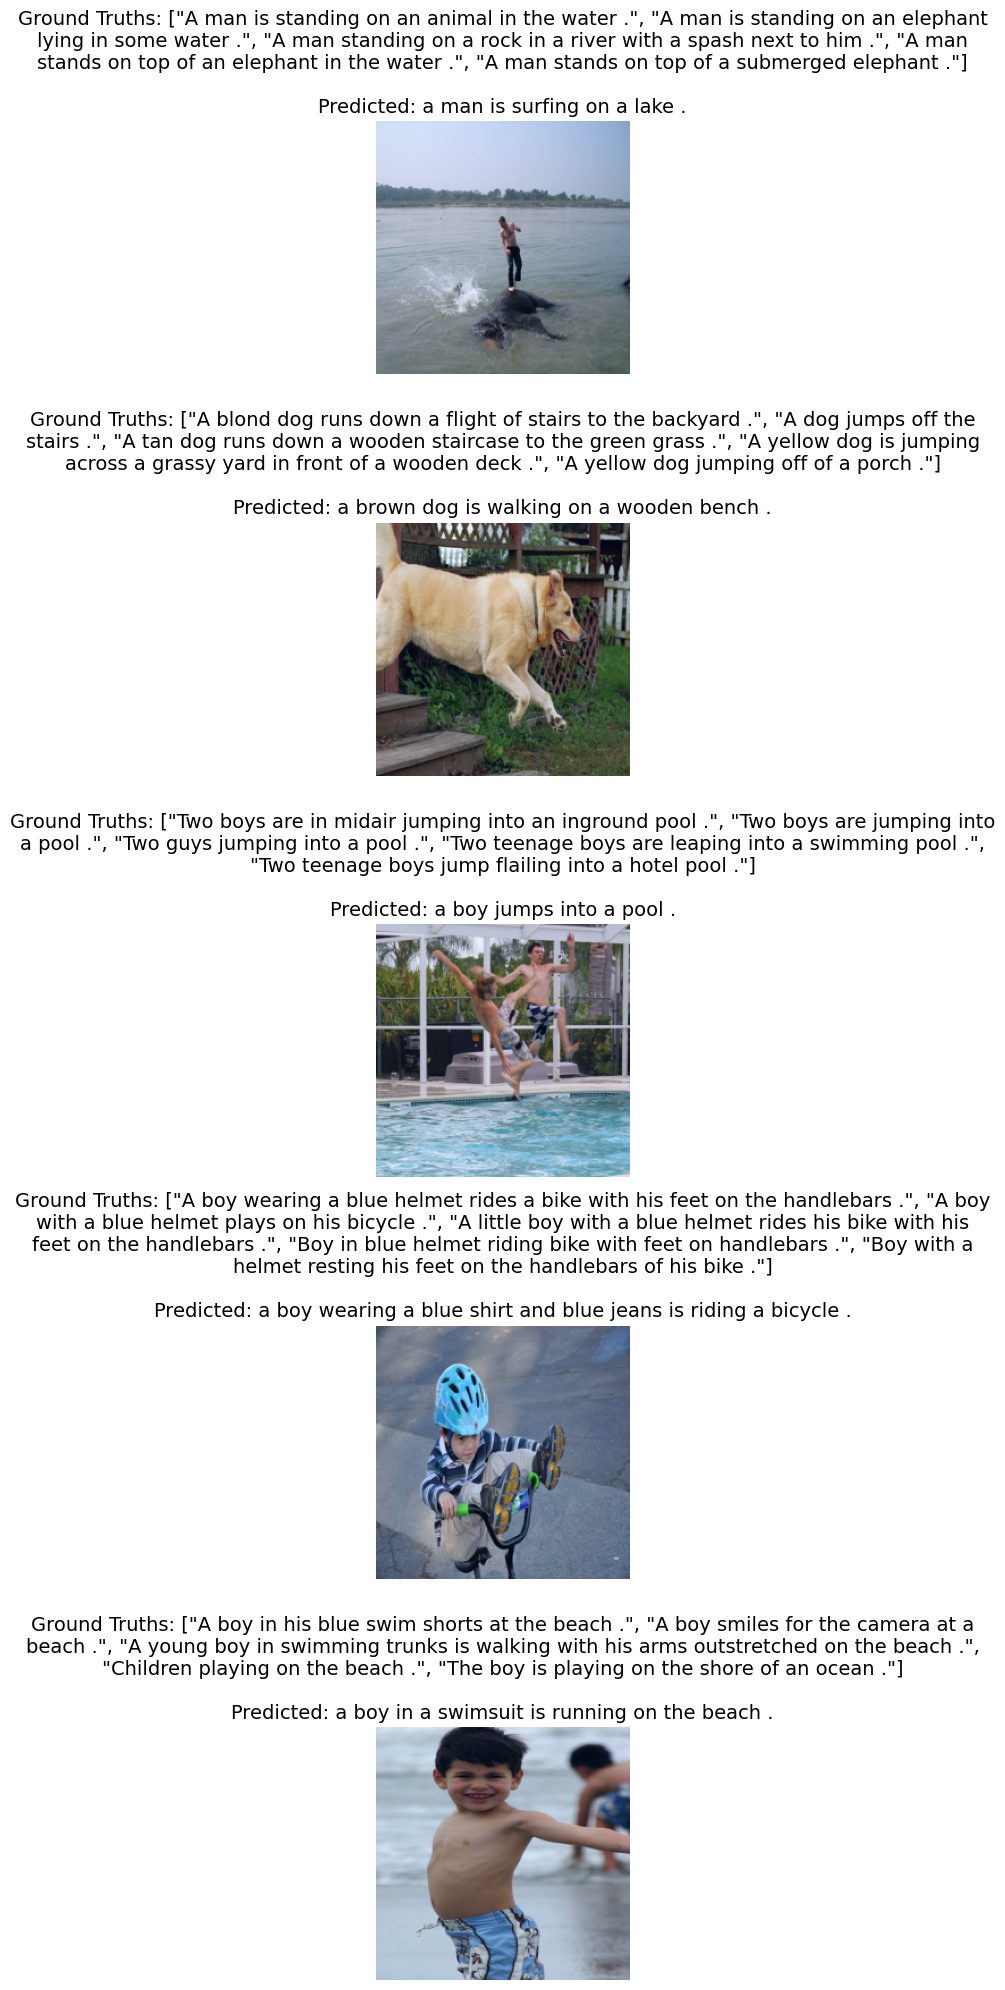

In [ ]:
# Show qualitative examples of the generated captions
show_qualitative_examples(
    encoder, decoder, test_dataset, train_dataset.vocab, ref_dict, num_examples=5
)


In [ ]:
# Function to compute word-level accuracy
def compute_word_accuracy(results):
    total_words = 0
    correct_words = 0

    for predicted_tokens, reference_tokens_list in results:
        # Choose the first reference (you can also average over all)
        reference_tokens = reference_tokens_list[0]
        length = min(len(predicted_tokens), len(reference_tokens))
        
        total_words += length
        correct_words += sum([predicted_tokens[i] == reference_tokens[i] for i in range(length)])
    
    accuracy = 100.0 * correct_words / total_words if total_words > 0 else 0.0
    print(f"Word-level accuracy: {accuracy:.2f}%")

In [ ]:
# Compute word-level accuracy
compute_word_accuracy(results)

Word-level accuracy: 17.60%


___
### Thank you